In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## T2 PvL

In [58]:
data = pd.read_csv('merge_denovo_BAlim_t2pvl.csv',sep=',', index_col = 0)
#data = data.T
data

,Urobilin,Sumaresinolic acid,Urobilin (NIST14),Urobilin (NIST14).1,Urobilin (NIST14).2,Urobilin (NIST14).3,Urobilin (NIST14).4,Tris(2-butoxyethyl) phosphate (NIST14),Phe-Pro (NIST14),Oleoyl L-carnitine (NIST14),...,f__S24-7.58,f__S24-7.59,g__Prevotella.2,f__S24-7.60,f__S24-7.61,g__Lactobacillus.7,f__S24-7.62,g__Prevotella.3,Week,Category
OTUID,,,,,,,,,,,,,,,,,,,,,
570.T2,0,0,5784,0,0,0,0,0,0,0,...,0,79,0,0,0,249,0,0,2,Placebo
571.T2,0,0,5344,0,0,0,0,0,0,0,...,75,0,0,0,0,0,0,0,2,Placebo
572.T2,0,32492,3693,0,0,0,0,0,0,0,...,0,0,0,0,46,0,0,122,2,Placebo
573.T2,0,0,2797,0,0,0,0,0,0,0,...,0,0,0,0,0,181,0,0,2,Placebo
574.T2,0,0,785,0,0,0,0,0,0,0,...,0,0,82,0,0,127,55,0,2,Placebo
575.T2,0,6970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,Placebo
576.T2,3033,6420,6646,4128,38906,0,0,0,0,0,...,100,0,56,0,0,72,0,0,2,Placebo
577.T2,27886,38434,2530,6712,43633,0,0,0,0,4051,...,0,0,37,0,0,0,0,0,2,Placebo
578.T2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,41,0,0,2,Letrozole


In [19]:
data.iloc[:,152]

OTUID
570.T2      Placebo
571.T2      Placebo
572.T2      Placebo
573.T2      Placebo
574.T2      Placebo
575.T2      Placebo
576.T2      Placebo
577.T2      Placebo
578.T2    Letrozole
580.T2    Letrozole
581.T2    Letrozole
582.T2    Letrozole
583.T2    Letrozole
584.T2    Letrozole
585.T2    Letrozole
586.T2    Letrozole
Name: Category, dtype: object

In [20]:
# Split the Groups from the dataset where y is category and x is data with species
y = data.iloc[:,152]
x = data.iloc[:,0:151]

In [21]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

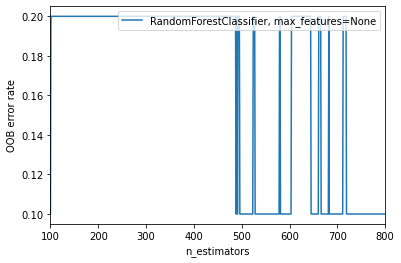

In [22]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 800

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [29]:
clf = RandomForestClassifier(n_estimators=500, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.8


In [30]:
clf_final = RandomForestClassifier(n_estimators=500, bootstrap=True,max_features=None,oob_score= True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.3333333333333333


In [31]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.6666666666666667

In [32]:
print(clf_final.oob_score_)

0.9


In [33]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

2      0.158
101    0.152
136    0.148
49     0.054
65     0.048
37     0.048
26     0.044
142    0.044
70     0.040
122    0.024
115    0.014
103    0.014
138    0.014
90     0.012
129    0.012
111    0.012
98     0.010
67     0.008
48     0.008
104    0.008
dtype: float64

In [34]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
Urobilin (NIST14),0.158
g__Bacteroides.2,0.152
g__Bacteroides.5,0.148
Bacosine,0.054
g__Lactobacillus,0.048
Linoleic acid methyl ester,0.048
f__S24-7.57,0.044
Oleanolic acid methyl ester,0.044
f__S24-7.5,0.040
g__Lactobacillus.5,0.024


In [35]:
imp.head(10).to_csv("RF_plot_time2_pvl.csv")

## T2 LvCoL

In [59]:
data = pd.read_csv('merge_denovo_BAlim_t2lvcol.csv',sep=',', index_col = 0)
#data = data.T
data

,α-Hyodeoxycholic acid methyl ester,α-Hyodeoxycholic acid methyl ester .1,α-Hyodeoxycholic acid methyl ester .2,α-Hyodeoxycholic acid methyl ester .3,α-Hyodeoxycholic acid methyl ester .4,α-Hyodeoxycholic acid methyl ester .5,α-Hyodeoxycholic acid methyl ester .6,α-Hyodeoxycholic acid methyl ester .7,β-Hyodeoxycholic acid,β-Hyodeoxycholic acid.1,...,f__S24-7.58,f__S24-7.59,g__Prevotella.2,f__S24-7.60,f__S24-7.61,g__Lactobacillus.7,f__S24-7.62,g__Prevotella.3,Week,Category
OTUID,,,,,,,,,,,,,,,,,,,,,
578.T2,0,0,0,0,0,0,0,22266,0,0,...,0,0,0,0,0,41,0,0,2,Letrozole
580.T2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,203,0,87,165,0,2,Letrozole
581.T2,3569,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,145,0,2,Letrozole
582.T2,0,0,0,0,0,0,0,76694,0,11171,...,0,135,0,0,0,47,0,0,2,Letrozole
583.T2,0,0,0,0,0,0,0,67035,0,0,...,0,31,0,0,0,205,0,0,2,Letrozole
584.T2,0,17388,0,0,0,0,0,0,0,0,...,0,0,0,0,0,79,55,134,2,Letrozole
585.T2,0,0,0,0,0,0,40110,40855,0,0,...,0,0,95,0,0,0,0,41,2,Letrozole
586.T2,0,0,0,0,0,0,0,16858,0,0,...,0,0,70,0,0,0,0,54,2,Letrozole
589.T2,0,0,0,0,0,25336,80104,0,0,0,...,0,0,0,149,0,0,0,0,2,Co-L


In [61]:
data.iloc[:,246]

OTUID
578.T2    Letrozole
580.T2    Letrozole
581.T2    Letrozole
582.T2    Letrozole
583.T2    Letrozole
584.T2    Letrozole
585.T2    Letrozole
586.T2    Letrozole
589.T2         Co-L
593.T2         Co-L
595.T2         Co-L
597.T2         Co-L
599.T2         Co-L
601.T2         Co-L
603.T2         Co-L
Name: Category, dtype: object

In [62]:
# Split the Groups from the dataset where y is category and x is data with species
y = data.iloc[:,246]
x = data.iloc[:,0:245]

In [63]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

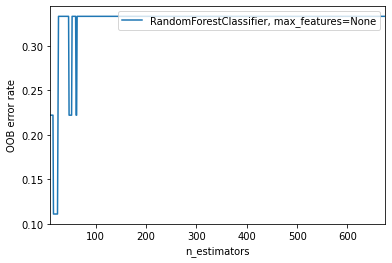

In [64]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [65]:
clf = RandomForestClassifier(n_estimators=300, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

/home/basilin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Mean Validation Scores: 0.7


In [67]:
clf_final = RandomForestClassifier(n_estimators=50, bootstrap=True, max_depth=10, max_features=None,
                                   random_state= 42, min_samples_split=.7)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.3333333333333333


In [68]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

In [69]:
print(oob_error)

0.33333333333333337


In [70]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

208    0.214286
103    0.142857
115    0.071429
141    0.071429
213    0.071429
91     0.071429
147    0.071429
139    0.071429
74     0.071429
40     0.071429
160    0.071429
244    0.000000
80     0.000000
82     0.000000
81     0.000000
83     0.000000
84     0.000000
85     0.000000
79     0.000000
76     0.000000
dtype: float64

In [71]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
f__S24-7.36,0.214286
Cholic acid (NIST14).5,0.142857
f__S24-7.40,0.071429
Cholic acid (NIST14).17,0.071429
β-Muricholic acid.11,0.071429
f__S24-7.2,0.071429
Ursocholic acid.3,0.071429
3β-Hydroxy-5-cholenoic acid (NIST14).1,0.071429
Taurocholic acid.1,0.071429
Cholic acid.8,0.071429


In [72]:
imp.head(10).to_csv("RF_plot_time2_lvcol.csv")

## T5 LvCoL

In [73]:
data = pd.read_csv('merge_denovo_BAlim_t5lvcol.csv',sep=',', index_col = 0)
#data = data.T
data

,α-Hyodeoxycholic acid methyl ester,α-Hyodeoxycholic acid methyl ester .1,α-Hyodeoxycholic acid methyl ester .2,α-Hyodeoxycholic acid methyl ester .3,α-Hyodeoxycholic acid methyl ester .4,α-Hyodeoxycholic acid methyl ester .5,α-Hyodeoxycholic acid methyl ester .6,α-Hyodeoxycholic acid methyl ester .7,β-Hyodeoxycholic acid,β-Hyodeoxycholic acid.1,...,f__S24-7.58,f__S24-7.59,g__Prevotella.2,f__S24-7.60,f__S24-7.61,g__Lactobacillus.7,f__S24-7.62,g__Prevotella.3,Week,Category
OTUID,,,,,,,,,,,,,,,,,,,,,
578.T5,4451,182669,0,0,0,0,0,3662,1254,0,...,0,0,0,180,0,173,0,120,5,Letrozole
580.T5,0,0,0,0,0,0,64559,10891,0,0,...,130,0,0,98,0,34,0,0,5,Letrozole
581.T5,0,0,0,0,0,0,0,25466,0,0,...,115,0,0,91,0,0,0,0,5,Letrozole
582.T5,7304,29807,0,0,0,0,0,11725,0,0,...,0,0,0,0,0,0,0,0,5,Letrozole
583.T5,0,0,0,0,0,0,0,0,0,0,...,0,61,45,0,0,0,0,45,5,Letrozole
584.T5,0,0,0,0,0,61532,0,131889,0,0,...,94,29,0,74,0,66,0,52,5,Letrozole
585.T5,0,0,0,0,0,0,0,0,11549,0,...,0,0,0,0,0,0,0,0,5,Letrozole
586.T5,0,0,0,0,0,0,0,0,0,0,...,167,0,0,0,0,0,0,0,5,Letrozole
589.T5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,166,0,178,0,0,5,Co-L


In [38]:
data.iloc[:,191]

SampleID
578.T5    Letrozole
580.T5    Letrozole
581.T5    Letrozole
582.T5    Letrozole
583.T5    Letrozole
584.T5    Letrozole
585.T5    Letrozole
586.T5    Letrozole
589.T5         Co-L
591.T5         Co-L
593.T5         Co-L
595.T5         Co-L
597.T5         Co-L
599.T5         Co-L
Name: Category, dtype: object

In [74]:
# Split the Groups from the dataset where y is category and x is data with species
y = data.iloc[:,246]
x = data.iloc[:,0:245]

In [75]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

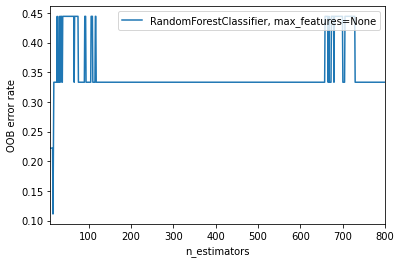

In [76]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 800

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [77]:
clf = RandomForestClassifier(n_estimators=200, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

/home/basilin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Mean Validation Scores: 0.7


In [78]:
clf_final = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features=None,
                                   random_state= 40)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.4


In [79]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.8333333333333334

In [80]:
print(oob_error)

0.33333333333333337


In [81]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

192    0.153061
40     0.056122
232    0.056122
21     0.051020
214    0.051020
125    0.040816
236    0.030612
50     0.030612
221    0.030612
57     0.025510
181    0.025510
112    0.025510
204    0.020408
73     0.020408
122    0.020408
91     0.020408
242    0.015306
134    0.015306
140    0.015306
212    0.015306
dtype: float64

In [82]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
f__S24-7.24,0.153061
f__S24-7.54,0.056122
β-Muricholic acid.11,0.056122
β-Hyodeoxycholic acid.13,0.051020
f__S24-7.41,0.051020
Deoxycholic acid (NIST14).5,0.040816
f__S24-7.47,0.030612
γ-Muricholic acid.6,0.030612
f__S24-7.57,0.030612
γ-Muricholic acid.13,0.025510


In [83]:
imp.head(10).to_csv("RF_plot_time5_lvcol.csv")

## T5 PvL

In [84]:
data = pd.read_csv('merge_denovo_BAlim_t5pvl.csv',sep=',', index_col = 0)
#data = data.T
data

,α-Hyodeoxycholic acid methyl ester,α-Hyodeoxycholic acid methyl ester .1,α-Hyodeoxycholic acid methyl ester .2,α-Hyodeoxycholic acid methyl ester .3,α-Hyodeoxycholic acid methyl ester .4,α-Hyodeoxycholic acid methyl ester .5,α-Hyodeoxycholic acid methyl ester .6,α-Hyodeoxycholic acid methyl ester .7,β-Hyodeoxycholic acid,β-Hyodeoxycholic acid.1,...,f__S24-7.58,f__S24-7.59,g__Prevotella.2,f__S24-7.60,f__S24-7.61,g__Lactobacillus.7,f__S24-7.62,g__Prevotella.3,Week,Category
OTUID,,,,,,,,,,,,,,,,,,,,,
570.T5,0,0,170150,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,31,5,Placebo
571.T5,0,0,0,0,0,0,0,0,0,0,...,0,252,43,0,0,0,0,69,5,Placebo
572.T5,0,0,0,0,0,0,0,0,0,0,...,0,182,0,123,0,0,0,164,5,Placebo
573.T5,0,0,0,0,0,0,0,0,0,0,...,97,37,0,83,0,0,0,0,5,Placebo
574.T5,0,0,0,0,0,0,0,0,0,0,...,84,0,0,99,0,0,0,32,5,Placebo
575.T5,0,31465,0,0,0,0,0,10307,0,0,...,93,0,65,82,0,0,0,51,5,Placebo
576.T5,0,0,0,0,0,0,0,0,0,0,...,52,0,0,84,0,175,0,0,5,Placebo
577.T5,0,0,0,0,0,0,0,11108,0,0,...,0,0,79,0,31,0,0,73,5,Placebo
578.T5,4451,182669,0,0,0,0,0,3662,1254,0,...,0,0,0,180,0,173,0,120,5,Letrozole


In [73]:
data.iloc[:,191]

SampleID
570.T5      Placebo
571.T5      Placebo
572.T5      Placebo
573.T5      Placebo
574.T5      Placebo
575.T5      Placebo
576.T5      Placebo
577.T5      Placebo
578.T5    Letrozole
580.T5    Letrozole
581.T5    Letrozole
582.T5    Letrozole
583.T5    Letrozole
584.T5    Letrozole
585.T5    Letrozole
586.T5    Letrozole
Name: Category, dtype: object

In [85]:
# Split the Groups from the dataset where y is category and x is data with species
y = data.iloc[:,246]
x = data.iloc[:,0:245]

In [86]:
# Split the data into training and test data for the categories(y) and dataset(x)
# Here we are spliting it 65% training and 35% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=42)

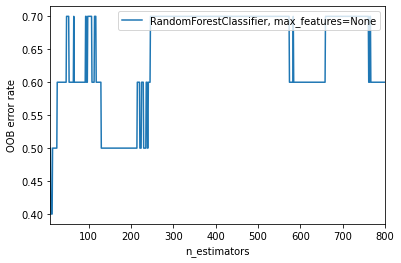

In [87]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 800


for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [88]:
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.7


In [90]:
clf_final = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features=None,oob_score=True,
                                   random_state= 42)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.5


In [91]:
print(clf_final.oob_score_)

0.5


In [92]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feature_importance.head(20)

212    0.115000
232    0.100000
86     0.085000
219    0.083333
190    0.080000
221    0.043333
226    0.043333
207    0.040000
122    0.040000
188    0.031667
199    0.025000
165    0.020000
237    0.020000
191    0.020000
65     0.018333
193    0.016667
227    0.015000
210    0.015000
211    0.015000
164    0.010000
dtype: float64

In [93]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data.columns, clf_final.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
imp=importances.sort_values(by='Gini-importance',ascending=False)
imp.head(20)

,Gini-importance
f__S24-7.39,0.115000
f__S24-7.54,0.100000
12-Ketodeoxycholic acid (NIST14).2,0.085000
f__S24-7.45,0.083333
f__Rikenellaceae,0.080000
g__Bacteroides.4,0.043333
f__S24-7.47,0.043333
Deoxycholic acid (NIST14).2,0.040000
f__S24-7.35,0.040000
f__S24-7.23,0.031667


In [ ]:
imp.head(10).to_csv("RF_plot_time5_pvl.csv")